Compare SSH and residuals from East Coast model to observations

In [1]:
import datetime
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
from dateutil import tz
import os
import glob
import csv
import pandas as pd

from salishsea_tools import nc_tools, stormtools
from nowcast import figures

%matplotlib inline

In [2]:
f = nc.Dataset('/ocean/nsoontie/MEOPAR/JP_SSH/SSH_N06_NANCY/NEP036-N06_IN_20140102_00000720_grid_2D.nc')

ssh = f.variables['sossheig'][:]
time = f.variables['time_counter']
dates = nc.num2date(time[:], time.units)

lats= f.variables['nav_lat'][:]
lons = f.variables['nav_lon'][:]


Where is the data?

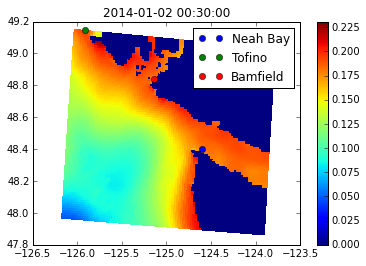

In [3]:
t=0
plt.pcolormesh(lons,lats,ssh[t,:,:])
plt.colorbar()
plt.title(dates[t])
names = ['Neah Bay', 'Tofino', 'Bamfield'] 
SITES=figures.SITES
for name in names:
    plt.plot(SITES[name]['lon'], SITES[name]['lat'],'o',label=name)
plt.legend(loc=0)

I can possibly check ssh for Tofino, Bamfield, Neah Bay.. Maybe some more NOAA stations in the future

# Plot time series

Mean removed from observations and model over the same time period.

In [4]:
f=nc.MFDataset('/ocean/nsoontie/MEOPAR/JP_SSH/SSH_N06_NANCY/NEP*.nc')


In [5]:
tols = {'Neah Bay': (.0045,.03), 'Tofino': (0.008,0.06), 'Bamfield': (0.005,0.06)}
sshs = {}
for name in names:
    j,i = figures.find_model_point(SITES[name]['lon'], SITES[name]['lat'],
                              lons, lats, tol_lon =tols[name][0], tol_lat = tols[name][1])
    sshs[name] = f.variables['sossheig'][:,j,i]
    sshs[name] = sshs[name][:,0,0]-np.nanmean(sshs[name][:,0,0])
times = f.variables['time_counter']
dates=nc.num2date(times[:], time.units)
dates = [ d.replace(tzinfo=tz.tzutc()) for d in dates]

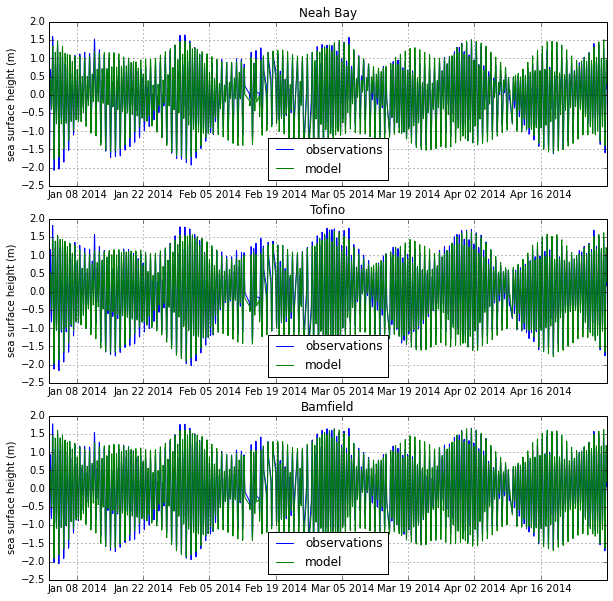

In [6]:
sdt = datetime.datetime(2013,12,31)
edt = datetime.datetime(2014,5,1)
fig, axs = plt.subplots(3,1,figsize=(10,10))
obs_interp={}
for name,ax in zip(names, axs):
    if name == 'Neah Bay':
        obs = figures.get_NOAA_wlevels(SITES[name]['stn_no'], 
                                      sdt.strftime('%d-%b-%Y'), edt.strftime('%d-%b-%Y'),
                                      product='hourly_height')
    else:    
        obs= figures.load_archived_observations(name, sdt.strftime('%d-%b-%Y'), edt.strftime('%d-%b-%Y'))
    obs_interp[name] = np.array(figures.interp_to_model_time(dates, obs.wlev, obs.time))
    obs_interp[name] = obs_interp[name]- np.nanmean(obs_interp[name])
    ax.plot(dates, obs_interp[name] ,label = 'observations')
    ax.plot(dates, sshs[name], label = 'model')
    ax.set_title(name)
    ax.set_ylabel('sea surface height (m)')
    ax.legend(loc=0)
    ax.grid()

# Residual time series

Tides for model calculated by performing a ttide analysis on the model time series.

Tides for observations calculated by performing a ttide analysis on observed time series in 2014.

In [7]:
def dateParser(s):
    #convert the string to a datetime object
    unaware = datetime.datetime.strptime(s, "%d-%b-%Y %H:%M:%S ")
    #add in UTC time zone
    aware = unaware.replace(tzinfo=tz.tzutc())
    return aware

In [8]:
def load_tides(fname):
        #read msl
    line_number = 1
    with open(fname) as f:
        mycsv = csv.reader(f); mycsv = list(mycsv)
        msl = mycsv[line_number][1]
        msl=float(msl)

    ttide = pd.read_csv(fname,skiprows=3,parse_dates=[0],date_parser=dateParser)
    ttide = ttide.rename(columns={'Time_UTC ': 'time', ' pred ': 'pred'})

    return ttide, msl

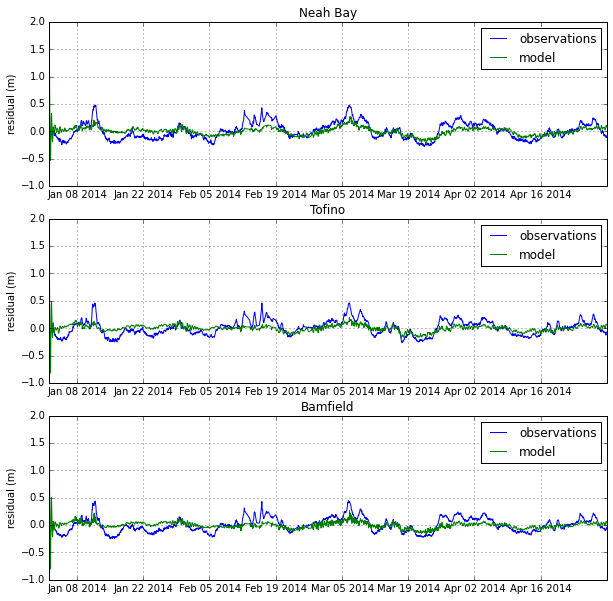

In [9]:
tide_path_model = '/ocean/nsoontie/MEOPAR/JP_SSH/SSH_N06_NANCY/'
tide_path = '/data/nsoontie/MEOPAR/analysis/storm_surges/data/'
sdt = datetime.datetime(2013,12,31)
edt = datetime.datetime(2014,5,1)
fig, axs = plt.subplots(3,1,figsize=(10,10))
res_obs={}
res_model={}
for name,ax in zip(names, axs):
    #Tides for model
    tidefile=glob.glob(os.path.join(tide_path_model,'{}_tidal_prediction_*'.format(name)))
    model_tides, msl = load_tides(tidefile[0])
    model_tides_interp = np.array(figures.interp_to_model_time(dates, model_tides.pred, model_tides.time))
    #Tides for observations
    obs_tides, msl = stormtools.load_tidal_predictions(
        os.path.join(tide_path,'{}_tidal_prediction_31-Dec-2013_01-Jan-2015.csv'.format(name)))
    obs_tides_interp = np.array(figures.interp_to_model_time(dates, obs_tides.pred_all, obs_tides.time))
    #residuals
    res_obs[name] = obs_interp[name] - obs_tides_interp
    res_model[name] = sshs[name] - model_tides_interp
    ax.plot(dates, res_obs[name],label = 'observations')
    ax.plot(dates, res_model[name], label = 'model')
    ax.set_title(name)
    ax.set_ylabel('residual (m)')
    ax.legend(loc=0)
    ax.grid()

* Model residuals were calculated by removing a tidal prediction generated with harmonic analysis of model time series. Constituents for Neah Bay with >1 cm amplitude and snr >2  included O1,K1,J1,M2,S2,N2,ETA2,MO3,M4. The model was only forced with M2,S2,N2,K1,O1.
* We might be able to apply a correction based on the missing, but significant consitutents like Q1, P1, K2.

# Scatter - water level

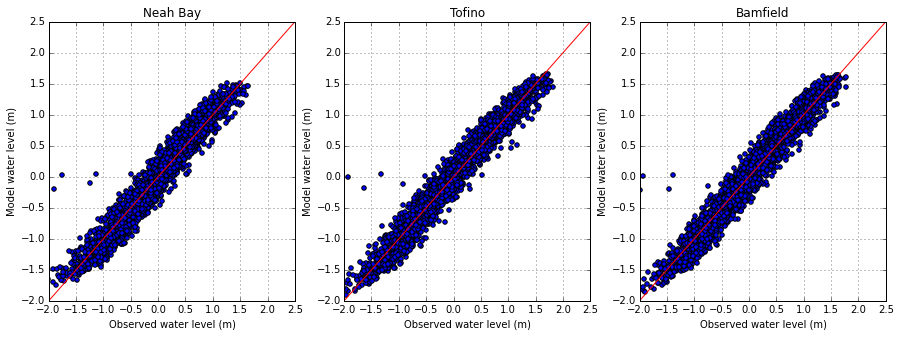

In [10]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
for name,ax in zip(names, axs):

    ax.scatter(obs_interp[name] , sshs[name])
    ax.set_title(name)
    ax.set_ylabel('Model water level (m)')
    ax.set_xlabel('Observed water level (m)')
    ax.grid()
    ax.set_ylim([-2,2.5])
    ax.set_xlim([-2,2.5])
    ax.plot([-2,2.5],[-2,2.5],'r-')

Weird outliers where the model is close to zero but the observations are not. Initialization?

# Scatter - residuals

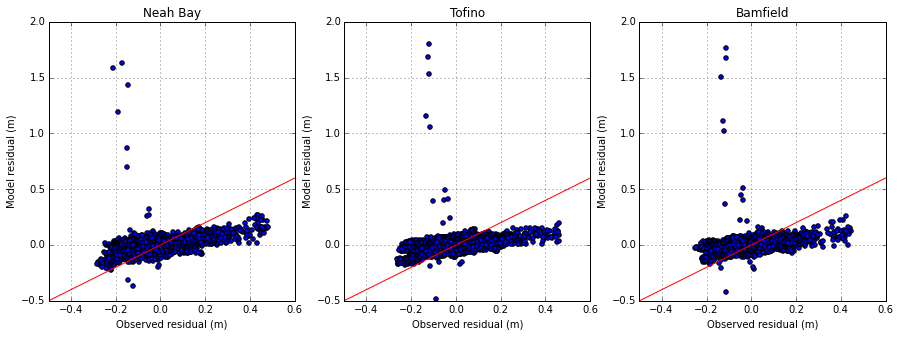

In [11]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
for name,ax in zip(names, axs):
    ax.scatter(res_obs[name], res_model[name])
    ax.set_title(name)
    ax.set_ylabel('Model residual (m)')
    ax.set_xlabel('Observed residual (m)')
    ax.grid()
    ax.set_ylim([-.5,2])
    ax.set_xlim([-.5,.6])
    ax.plot([-.5,1],[-.5,1],'r-')

* Larger surges (>20cm) are generally underpredicted by the model.
* I believe the outlieres are due to model intialization. They are removed if I exlcude the first 24 hours. 

# Water level error - time series
Error is observations-model

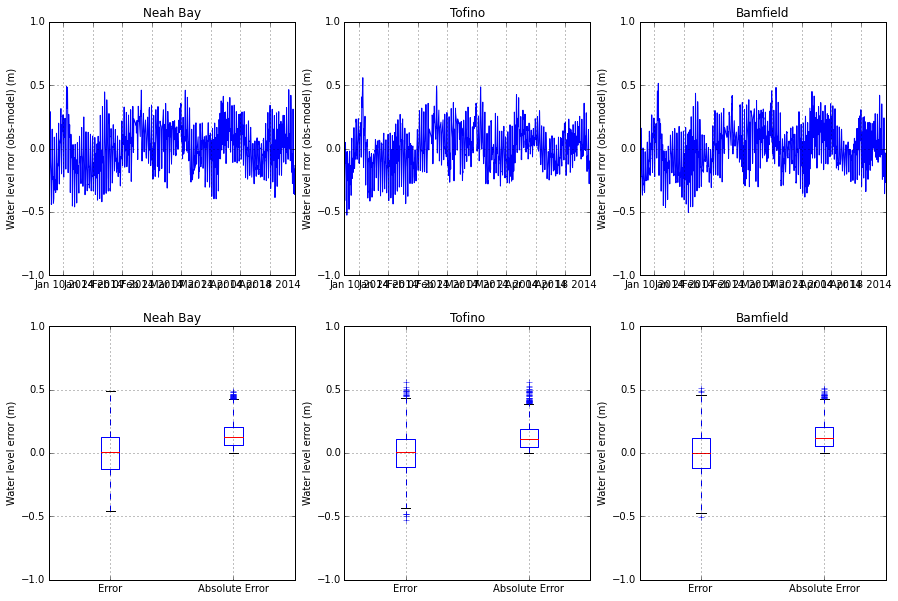

In [12]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
errors={}
for name,ax, axb in zip(names, axs[0,:], axs[1,:]):

    errors[name] = obs_interp[name][24:] - sshs[name][24:]
    ax.plot(dates[24:], errors[name])
    ax.set_title(name)
    ax.set_ylabel('Water level rror (obs-model) (m)')
    ax.set_ylim([-1,1])
    ax.grid()
    abs_err=np.abs(errors[name])
    
    axb.boxplot([errors[name], abs_err], labels=['Error', 'Absolute Error'])
    axb.set_title(name)
    axb.set_ylabel('Water level error (m)')
    axb.grid()
    axb.set_ylim([-1,1])

Note that outliers from initialization are removed.

# Residual error - time series

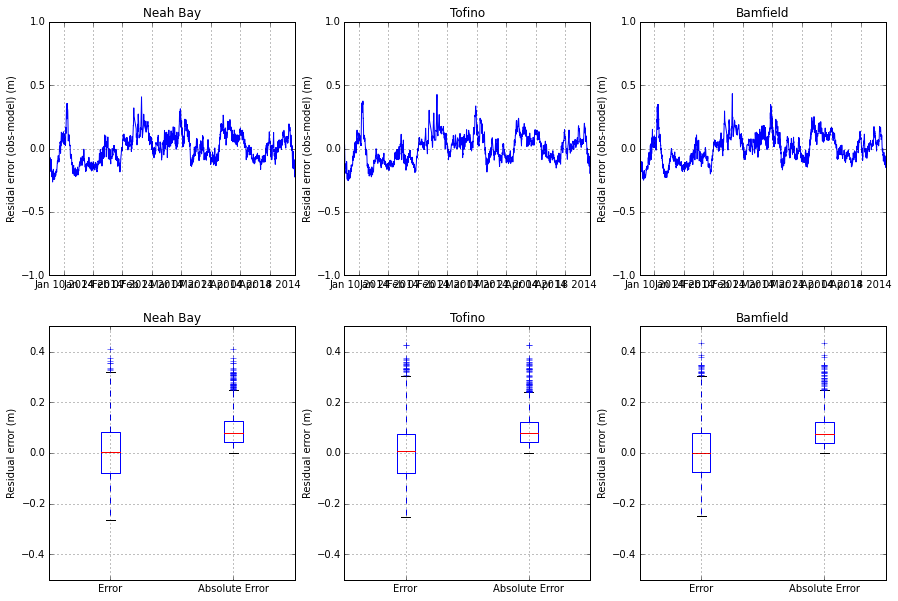

In [13]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
errors_res={}
for name,ax, axb in zip(names, axs[0,:], axs[1,:]):

    errors_res[name] = res_obs[name][24:] - res_model[name][24:]
    ax.plot(dates[24:], errors_res[name])
    ax.set_title(name)
    ax.set_ylabel('Residal error (obs-model) (m)')
    ax.set_ylim([-1,1])
    ax.grid()
    abs_err=np.abs(errors_res[name])
    
    axb.boxplot([errors_res[name], abs_err], labels=['Error', 'Absolute Error'])
    axb.set_title(name)
    axb.set_ylabel('Residual error (m)')
    axb.grid()
    axb.set_ylim([-.5,.5])

In [14]:
for name in names:
    ws_wlev = stormtools.willmott_skill(obs_interp[name][24:], sshs[name][24:])
    ws_res = stormtools.willmott_skill(res_obs[name][24:], res_model[name][24:])
    
    gamm_wlev = np.var(errors[name])/np.var(obs_interp[name][24:])
    gamm_res =  np.var(errors_res[name])/np.var(res_obs[name][24:])
    print(name)
    print('Water level Willmott score: {0:2g}'.format(ws_wlev ))
    print('Residual Willmott score: {0:2g}'.format(ws_res ))
    print('Water level gamma^2: {0:2g}'.format(gamm_wlev ))
    print('Residual gamma^2: {0:2g}'.format(gamm_res ))

Neah Bay
Water level Willmott score: 0.985113
Residual Willmott score: 0.718436
Water level gamma^2: 0.0621742
Residual gamma^2: 0.553894
Tofino
Water level Willmott score: 0.990136
Residual Willmott score: 0.640153
Water level gamma^2: 0.0398654
Residual gamma^2: 0.655475
Bamfield
Water level Willmott score: 0.988543
Residual Willmott score: 0.612269
Water level gamma^2: 0.0479989
Residual gamma^2: 0.693677


# Next

* Decide about applying a correction to predicted ssh. How much do the other constituents contribute? If we are only interested in residuals then does it matter that some constituents are missing? 
* Compare with the NOAA storm surge model and HYCOM. Does one perform better than the other?